
==================== Processing Grid Spacing: 0.5 degrees ====================
--- Creating mask for interp_mpas_3km_2023050100_mem1_f118.nc on a 0.5-deg grid ---
Found 6969 points inside the domain.
--- Creating mask for interp_fv3_3km_2023050100_mem1_f118.nc on a 0.5-deg grid ---
Found 6972 points inside the domain.

Creating comparison plot...


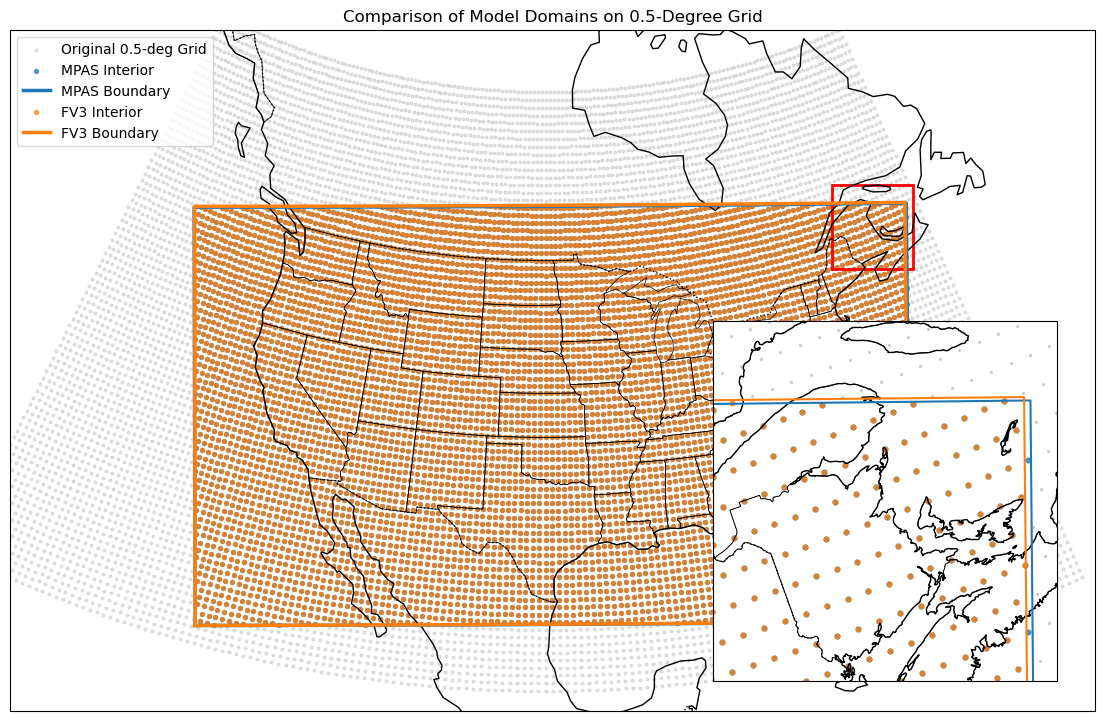


Creating and saving the intersection of the two masks...
Intersection mask successfully saved to: hwt_0.5deg_mask.nc

==================== Processing Grid Spacing: 0.25 degrees ====================
--- Creating mask for interp_mpas_3km_2023050100_mem1_f118.nc on a 0.25-deg grid ---
Found 27857 points inside the domain.
--- Creating mask for interp_fv3_3km_2023050100_mem1_f118.nc on a 0.25-deg grid ---
Found 27857 points inside the domain.

Creating comparison plot...


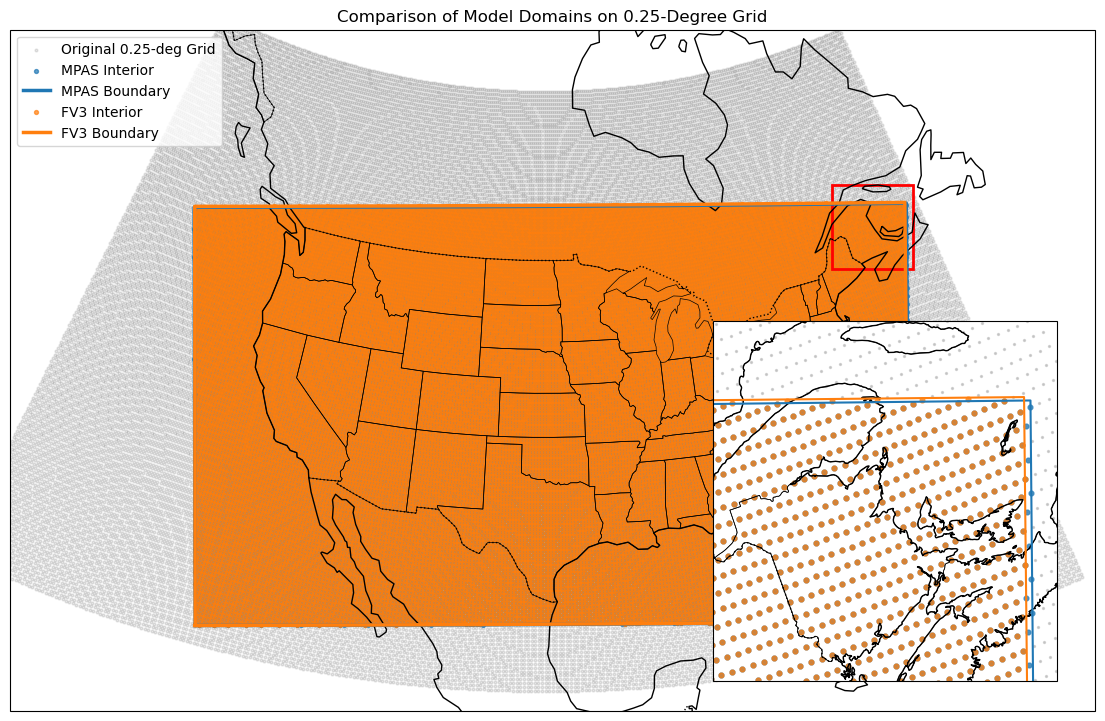


Creating and saving the intersection of the two masks...
Intersection mask successfully saved to: hwt_0.25deg_mask.nc


In [1]:
import numpy as np
import os
import xarray as xr
from matplotlib.path import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
from matplotlib.patches import Rectangle

def create_lambert_domain_mask(lambert_file_path, gs=0.5):
    """
    Creates a boolean mask on a regular lat-lon grid that identifies points
    falling inside a given Lambert Conformal grid domain.

    This function handles the data processing part only.

    Args:
        lambert_file_path (str): Path to the NetCDF file containing the
                                 Lambert grid definition.
        gs (float): The grid spacing in degrees for the regular lat-lon grid.

    Returns:
        dict: A dictionary containing the mask DataArray ('mask_da'),
              the boundary coordinates ('boundary_lons', 'boundary_lats'),
              the full grid points ('grid_points'), and the subset of
              points inside the domain ('subset_points').
    """
    print(f"--- Creating mask for {os.path.basename(lambert_file_path)} on a {gs}-deg grid ---")

    # --- 1. Define the Regular Lat-Lon Grid ---
    lat_vector = np.arange(20, 60 + gs, gs)
    lon_vector = np.arange(220, 300 + gs, gs)
    lon_grid, lat_grid = np.meshgrid(lon_vector, lat_vector)
    grid_points = np.vstack((lon_grid.ravel(), lat_grid.ravel())).T

    # --- 2. Load Lambert Grid Boundary ---
    try:
        with xr.open_dataset(lambert_file_path) as ds:
            lat = ds['latitude'].isel(time=0).values
            lon = ds['longitude'].isel(time=0).values + 360
    except (FileNotFoundError, KeyError) as e:
        print(f"FATAL ERROR: Could not process {lambert_file_path}. Reason: {e}")
        return None

    boundary_lons = np.concatenate([lon[0, :], lon[1:, -1], lon[-1, :-1][::-1], lon[:-1, 0][::-1]])
    boundary_lats = np.concatenate([lat[0, :], lat[1:, -1], lat[-1, :-1][::-1], lat[:-1, 0][::-1]])
    boundary_polygon_vertices = np.vstack((boundary_lons, boundary_lats)).T

    # --- 3. Perform Point-in-Polygon Test ---
    lambert_path = Path(boundary_polygon_vertices)
    mask_1d = lambert_path.contains_points(grid_points)
    subset_points = grid_points[mask_1d]

    # --- 4. Create xarray DataArray for the Mask ---
    mask_2d = mask_1d.reshape(lon_grid.shape)
    mask_da = xr.DataArray(
        mask_2d,
        coords={'latitude': lat_vector, 'longitude': lon_vector},
        dims=['latitude', 'longitude'],
        name='lambert_domain_mask'
    )
    mask_da.attrs['description'] = f"Boolean mask on a {gs}-degree grid. True = inside."
    mask_da.attrs['source_lambert_grid'] = lambert_file_path
    mask_da.attrs['creation_date'] = datetime.datetime.now(datetime.UTC).strftime('%Y-%m-%d %H:%M:%S UTC')

    print(f"Found {len(subset_points)} points inside the domain.")

    return {
        'mask_da': mask_da,
        'boundary_lons': boundary_lons,
        'boundary_lats': boundary_lats,
        'grid_points': grid_points,
        'subset_points': subset_points
    }

def plot_domain_masks(mask_data_list, colors, labels, gs):
    """
    Plots one or more domain masks on a single map to compare them.
    Includes an inset map zooming in on the northeast corner.

    Args:
        mask_data_list (list): A list of dictionaries, where each dictionary is
                               the output of create_lambert_domain_mask.
        colors (list): A list of color strings for plotting each mask.
        labels (list): A list of labels for the legend.
        gs (float): The grid spacing, used for the plot title.
    """
    print(f"\nCreating comparison plot...")
    fig = plt.figure(figsize=(14, 9))
    
    # Define projections
    map_proj = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.5)
    data_proj = ccrs.PlateCarree()

    # --- Main Axes ---
    ax = fig.add_subplot(1, 1, 1, projection=map_proj)
    ax.set_extent([-135, -60, 18, 60], crs=data_proj)

    # --- Inset Axes ---
    # Position: [left, bottom, width, height] in figure coordinates (moved to lower-right)
    ax_inset = fig.add_axes([0.55, 0.15, 0.4, 0.4], projection=map_proj)
    # New extent, 2x larger and covering the northeast corner of the main plot
    inset_extent = [-68, -62, 45, 49.5]
    ax_inset.set_extent(inset_extent, crs=data_proj)

    # Plot the full latlon grid on both axes
    ax.scatter(mask_data_list[0]['grid_points'][:, 0], mask_data_list[0]['grid_points'][:, 1],
               transform=data_proj, s=4, color='gray', alpha=0.2, label=f'Original {gs}-deg Grid')
    ax_inset.scatter(mask_data_list[0]['grid_points'][:, 0], mask_data_list[0]['grid_points'][:, 1],
               transform=data_proj, s=2, color='gray', alpha=0.3)


    # Loop through each mask's data and plot it on both the main and inset axes
    for data, color, label in zip(mask_data_list, colors, labels):
        # Plot the subsetted grid points
        ax.scatter(data['subset_points'][:, 0], data['subset_points'][:, 1],
                   transform=data_proj, s=8, color=color, alpha=0.7, label=f'{label} Interior')
        ax_inset.scatter(data['subset_points'][:, 0], data['subset_points'][:, 1],
                         transform=data_proj, s=12, color=color, alpha=0.7)
        
        # Plot the boundary with the same color
        ax.plot(data['boundary_lons'], data['boundary_lats'],
                transform=data_proj, color=color, linewidth=2.5, label=f'{label} Boundary')
        # Use a smaller linewidth for the inset plot
        ax_inset.plot(data['boundary_lons'], data['boundary_lats'],
                      transform=data_proj, color=color, linewidth=1.5)

    # Add map features to both axes
    for a in [ax, ax_inset]:
        a.add_feature(cfeature.COASTLINE)
        a.add_feature(cfeature.STATES, edgecolor='black', lw=0.5)
        a.add_feature(cfeature.BORDERS, linestyle=':')

    # Add a rectangle on the main plot to show the inset area
    # Transform the geographic bounding box to the axes' projection to draw a straight-sided rectangle.
    lons = [inset_extent[0], inset_extent[1], inset_extent[1], inset_extent[0]]
    lats = [inset_extent[2], inset_extent[2], inset_extent[3], inset_extent[3]]
    
    # Transform all 4 corners to the map's projection
    projected_corners = map_proj.transform_points(data_proj, np.array(lons), np.array(lats))
    
    # Get the bounding box of the projected corners
    x_min = np.min(projected_corners[:, 0])
    x_max = np.max(projected_corners[:, 0])
    y_min = np.min(projected_corners[:, 1])
    y_max = np.max(projected_corners[:, 1])
    
    # Define the rectangle in the axes' native coordinates
    rect_x = x_min
    rect_y = y_min
    rect_width = x_max - x_min
    rect_height = y_max - y_min
    
    # Add the patch. No transform is needed as coordinates are in the axes' projection.
    ax.add_patch(Rectangle((rect_x, rect_y), rect_width, rect_height,
                           edgecolor='red', facecolor='none', lw=2))
    
    ax.set_title(f"Comparison of Model Domains on {gs}-Degree Grid")
    ax.legend(loc="upper left")

    # Show the plot directly in the notebook
    plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    mpas_file = '/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023050100/post/mem_1/interp_mpas_3km_2023050100_mem1_f118.nc'
    fv3_file = '/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023050100/post/mem_1/interp_fv3_3km_2023050100_mem1_f118.nc'

    for gs in [0.5, 0.25]:
        print(f"\n{'='*20} Processing Grid Spacing: {gs} degrees {'='*20}")
        # 1. Create masks for each model domain
        mpas_data = create_lambert_domain_mask(mpas_file, gs)
        fv3_data = create_lambert_domain_mask(fv3_file, gs)

        if mpas_data and fv3_data:
            # 2. Plot both masks on the same map for comparison
            plot_domain_masks(
                mask_data_list=[mpas_data, fv3_data],
                colors=['#1f77b4', '#ff7f0e'],  # Blue and Orange
                labels=['MPAS', 'FV3'],
                gs=gs
            )

            # 3. Create the intersection of both masks
            print("\nCreating and saving the intersection of the two masks...")
            intersection_mask = mpas_data['mask_da'] & fv3_data['mask_da']
            intersection_mask.attrs['description'] = f"Boolean mask for the INTERSECTION of the MPAS and FV3 domains on a {gs}-degree grid."

            # 4. Save the final intersection mask to a NetCDF file
            output_mask_filename = f"hwt_{gs}deg_mask.nc"
            if os.path.exists(output_mask_filename):
                os.remove(output_mask_filename)
            intersection_mask.to_netcdf(output_mask_filename)
            print(f"Intersection mask successfully saved to: {output_mask_filename}")


In [5]:
mpas_mask = mask.copy()

In [7]:
mask.equals(mpas_mask)

False

In [11]:
mpas_mask.sum()

<xarray.DataArray 'lambert_domain_mask' ()> Size: 8B
array(27857)

In [20]:
(mask == mpas_mask).all()

<xarray.DataArray 'lambert_domain_mask' ()> Size: 1B
array(False)

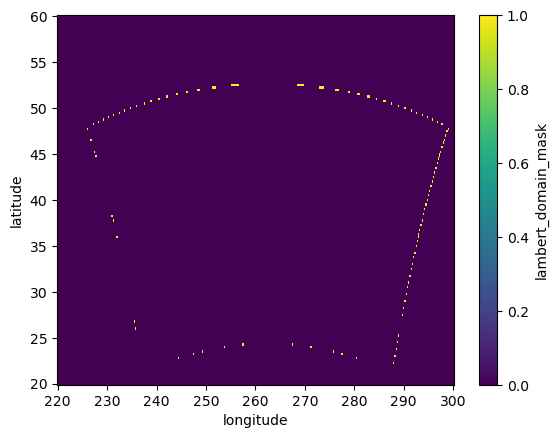

In [21]:
(mask != mpas_mask).plot()

In [16]:
mpas_mask

<xarray.DataArray 'lambert_domain_mask' (latitude: 161, longitude: 321)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 20.0 20.25 20.5 20.75 ... 59.5 59.75 60.0
  * longitude  (longitude) float64 3kB 220.0 220.2 220.5 ... 299.5 299.8 300.0
Attributes:
    description:           Boolean mask indicating points inside the Lambert ...
    source_lambert_grid:   /glade/campaign/mmm/parc/schwartz/HWT2023/mpas/202...
    grid_spacing_degrees:  0.25
    creation_date:         2025-07-18 21:24:21 UTC
    long_name:             Lambert Domain Mask
    units:                 boolean

In [27]:
fv3 = xr.open_dataset("/glade/campaign/mmm/parc/schwartz/HWT2023/fv3/2023050100/post/mem_1/interp_fv3_3km_2023050100_mem1_f118.nc")
mpas = xr.open_dataset("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023050100/post/mem_1/interp_mpas_3km_2023050100_mem1_f118.nc")
fv3

<xarray.Dataset> Size: 594MB
Dimensions:          (time: 1, lat: 1059, lon: 1799)
Dimensions without coordinates: time, lat, lon
Data variables: (12/78)
    latitude         (time, lat, lon) float32 8MB ...
    longitude        (time, lat, lon) float32 8MB ...
    REFC             (time, lat, lon) float32 8MB ...
    CAPEsfc          (time, lat, lon) float32 8MB ...
    UGRD925          (time, lat, lon) float32 8MB ...
    UGRD850          (time, lat, lon) float32 8MB ...
    ...               ...
    DPT2m            (time, lat, lon) float32 8MB ...
    PRATEsfc         (time, lat, lon) float32 8MB ...
    PRATEsfc_accum   (time, lat, lon) float32 8MB ...
    UGRD10m          (time, lat, lon) float32 8MB ...
    VGRD10m          (time, lat, lon) float32 8MB ...
    SPFH2m           (time, lat, lon) float32 8MB ...
Attributes:
    initializationTime:  2023050100
    forecastHour:        118
    DX:                  3000.0

In [28]:
mpas

<xarray.Dataset> Size: 511MB
Dimensions:                 (time: 1, lat: 1059, lon: 1799)
Dimensions without coordinates: time, lat, lon
Data variables: (12/67)
    latitude                (time, lat, lon) float32 8MB ...
    longitude               (time, lat, lon) float32 8MB ...
    refl10cm_max            (time, lat, lon) float32 8MB ...
    updraft_helicity_max    (time, lat, lon) float32 8MB ...
    w_velocity_max          (time, lat, lon) float32 8MB ...
    wind_speed_10m_max      (time, lat, lon) float32 8MB ...
    ...                      ...
    ushr01                  (time, lat, lon) float32 8MB ...
    vshr01                  (time, lat, lon) float32 8MB ...
    updraft_helicity_max03  (time, lat, lon) float32 8MB ...
    grpl_max                (time, lat, lon) float32 8MB ...
    updraft_helicity_max01  (time, lat, lon) float32 8MB ...
    rvort1_max              (time, lat, lon) float32 8MB ...
Attributes:
    initializationTime:  2023050100
    forecastHour:        118
    DX:                  3000.0

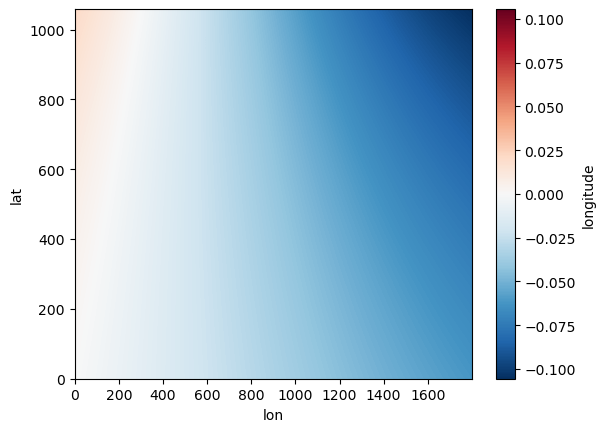

In [31]:
(fv3.longitude - mpas.longitude).plot()